In [6]:
#필요한 라이브러리 호출
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp

In [20]:
# 엑셀 파일 불러오기
# 채원이가 고친 마지막 파이널데이터로 함
filename = 'master_data_final.xlsx'
data = pd.read_excel(filename)

In [8]:
# 데이터 쭉 보고 싶으면 호출
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

## Feature engineering

In [21]:
# 펀딩시작요일 원핫인코딩
# 라벨인코딩후 카테고리타입으로 변환하나 원핫인코딩하나 별반 차이 없어서 원핫인코딩으로감
data = pd.concat([data,pd.get_dummies(data['펀딩시작요일'])],axis=1)

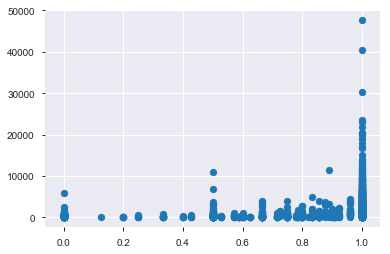

In [5]:
plt.scatter(data.과거성공프로젝트수/data.과거프로젝트수, data.달성률)

In [ ]:
#파생변수- 성공비율 0/0 nan값 처리?
data['성공비율'] = data.과거성공프로젝트수/data.과거프로젝트수

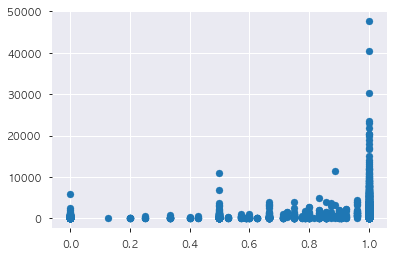

In [10]:
# 이렇게 하는게 더 값이 잘나와서 그냥 이렇게 하자
# 다른 방법있으면 적용해봐도 될듯
data = data[(data.과거성공프로젝트수/data.과거프로젝트수)<=1]  # 새로펀딩한 0/0 인 애들 빼자는 거지?

plt.scatter(data.과거성공프로젝트수/data.과거프로젝트수, data.달성률)
data['성공비율'] = data.과거성공프로젝트수/data.과거프로젝트수

In [22]:
# 펀딩기간 형성 및 정수로 변환

data['펀딩기간'] = (data['펀딩마감날짜'] - data['펀딩시작날짜'])
data['펀딩기간'] = data.펀딩기간.dt.days

# 사용한 날짜 변수 다시 제거

#data = data.drop(columns = ['펀딩시작날짜','펀딩마감날짜'])
# 펀딩기간 0인거 제거

data = data[data['펀딩기간']!=0]

# 일단 하면 성능좋아져서 했음


In [23]:
# 일펀딩금액과 일글수 파생변수 생성

data['일펀딩금액'] = data.목표금액/data.펀딩기간
data['일글수'] = data.글업데이트수/data.펀딩기간

In [ ]:
# 일평균 글업데이트수와 중복되는 컬럼이기 때문에 제거 or 지켜보자
#['글업데이트수','과거성공프로젝트수','목표금액'])

In [24]:
# 파생변수

data['문장당강조'] = data.Strong/data.문장수
data['문장당밑줄']= data.Under/data.문장수

In [ ]:
data.columns

In [ ]:
data.head(1)

## Feature Selection

In [25]:
# 필요한 컬럼만 추출
#좋아요/서포터/글업데이트/댓글수x
#와디즈,크라우드펀딩기사개수/경제지표x
#인스타존재여부/인스타팔로워수x
feature_names=['달성률',#정답값
               '목표금액', 
               '리워드종류수',
               '이미지수',
               '비디오수',
               '마감배송차이',
               '와디즈팔로워수',
               '과거프로젝트수',
               '과거성공프로젝트수',
               '앵콜펀딩여부',
               '음절수',
               '단어수',
               '문장수',
               'Strong',
               'Under',
               '가독성',
               '가독성2', 
              '제목단어수', 
               '디자인소품',
               '반려동물',
               '뷰티',
               '스포츠·모빌리티',
              '여행·레저',
               '테크·가전',
               '패션·잡화',
               '푸드', 
               '홈리빙',
               'Fri',
               'Mon',
               'Sat',
               'Sun',
               'Thu',
               'Tue',
               'Wed',
               #'성공비율',
               '펀딩기간',
               '일펀딩금액',
               '일글수',
              '문장당강조',
               '문장당밑줄']
total = data[feature_names]

In [ ]:
# 달성률을 너무 계속 자르면 좋진 않을거 같고 3만정도 자르면 일단
# 70 -> 72%로 정확도 향상됐음

#total = total[total['달성률']<30000]

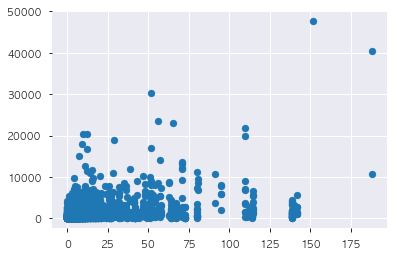

In [15]:
plt.scatter(total.와디즈팔로워수,total.달성률)

In [26]:
total.index = list(range(len(total))) #어디에 쓰려고?

In [27]:
# 달성률 범주생성
# 현재 범주는 임의의 범주이며
# 여러가지 시도하면서 정확도를 봐야할듯

total_target = total

target_list = []

for i in range(len(total_target)):
    if total_target.달성률[i] < 100:
        target_list.append(0)
    elif total_target.달성률[i] < 700:
        target_list.append(1)
    elif total_target.달성률[i] < 2000:
        target_list.append(2)
    elif total_target.달성률[i] < 5000:
        target_list.append(3)
    else:
        target_list.append(4)
    
total_target['타겟'] = target_list
total_data = total_target.drop(columns = ['달성률'])
total_target.pivot_table(index = '타겟', aggfunc = 'count', values = '달성률')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,달성률
타겟,
0,1115
1,2590
2,957
3,433
4,187


학습용 데이터 준비

In [ ]:
X = total_data.drop(columns=['타겟'])
y = total_data.타겟

# 학습용/테스트용 데이터 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

## Model Selection and evaluation

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

import sklearn.metrics as mt

print(mt.accuracy_score( y_pred, y_test))
print(mt.confusion_matrix(y_pred, y_test))

pd.DataFrame({'속성명':total_data.columns[:-1], '중요도':rf.feature_importances_}).sort_values('중요도',ascending=False)

1.0
0.6403785488958991
0.6403785488958991
[[247  62   2   0   0]
 [ 81 686 203  76  23]
 [  2  32  66  50  17]
 [  0   1   6  10  12]
 [  0   1   1   1   6]]


,속성명,중요도
35,일글수,0.185486
5,와디즈팔로워수,0.061415
34,일펀딩금액,0.053866
2,이미지수,0.050695
4,마감배송차이,0.043102
10,단어수,0.040932
9,음절수,0.040891
14,가독성,0.040866
11,문장수,0.040355
36,문장당강조,0.040019


In [29]:
import xgboost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

xgb_clf.score(X_test, y_test)

0.6473186119873817

In [ ]:
# gridsearch

from sklearn.model_selection import GridSearchCV

xgb_params = {'n_estimators':[100,200],
             'learning_rate':[0.1,0.2]}

grid_xgb = GridSearchCV(xgb_clf, param_grid = xgb_params,
               cv= 5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

grid_xgb.score(X_test,y_test)
grid_xgb.best_params_